In [1]:
from IPython.display import display;

import numpy as np;
import pandas as pd;

import torch;
from torchtext import data;

import os;

import matplotlib.pyplot as plt;
import seaborn as sns;

%matplotlib inline

sns.set();

# Build model

In [2]:
import torch;
import torch.nn as nn;

In [3]:
class RNN_Model(nn.Module):
    """
    Params:
        input_dim: size of vocabulary
        embedding_dim: size of embeddings
        hidden_dim: size of hidden units
        output_dim: size of output
    """
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNN_Model, self).__init__();
        self.embeddings = nn.Embedding(input_dim, embedding_dim);
        self.rnn = nn.RNN(embedding_dim, hidden_dim);
        self.fc = nn.Linear(hidden_dim, output_dim);
    
    def forward(self, text):
        embedding = self.embeddings(text);
        output, hidden = self.rnn(embedding);
        
        return self.fc(hidden.squeeze(0));

In [4]:
def accuracy(predicted, actual):
    preds = torch.round(torch.sigmoid(predicted));
    correct = (preds == actual).float();
    acc = correct.sum() / len(correct);
    
    return acc;

In [5]:
def train_model(model, iterator, optimizer, criterion):
    epoch_loss = 0;
    epoch_acc = 0;
    
    # put model in train mode
    model.train();
    
    for batch in iterator:
        optimizer.zero_grad();
        preds = model(batch.text).squeeze(1);
        loss = criterion(preds, batch.label);
        acc = accuracy(preds, batch.label);
        loss.backward();
        optimizer.step();
        
        epoch_loss += loss.item();
        epoch_acc += acc.item();
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator);

In [6]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0;
    epoch_acc = 0;
    
    model.eval();
    
    with torch.no_grad():
        for batch in iterator:
            preds = model(batch.text).squeeze(1);
            loss = criterion(preds, batch.label);
            acc = accuracy(preds, batch.label);
            
            epoch_loss += loss;
            epoch_acc += acc;
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator);

# convert all files to csv

In [7]:
for f in os.listdir('data'):
    if os.path.splitext(f)[1] == '.txt':
        data_file = np.loadtxt('data/' + f, dtype='object', delimiter='\t');
        df = pd.DataFrame(data_file, columns=['Sentiment', 'Label']);
        df.to_csv('data/' + os.path.splitext(f)[0] + '.csv', index=False);

# Load amazon datasets using pytorch tabular dataset

In [8]:
amazon_text = data.Field(sequential=True, use_vocab=True);
amazon_label = data.LabelField(dtype=torch.float);

fields = {
    'Sentiment': ('text', amazon_text),
    'Label': ('label', amazon_label)
};

amazon_train, amazon_val, amazon_test = data.TabularDataset.splits(
    path='data',
    train='amazon_train.csv',
    validation='amazon_dev.csv',
    test='amazon_test.csv',
    format='csv',
    fields=fields
);

# Build amazon vocabulary

In [9]:
VOCAB_SIZE = 2500;

amazon_text.build_vocab(
    amazon_train,
    max_size=VOCAB_SIZE
);

amazon_label.build_vocab(amazon_train);

print('Text vocabulary size: {}\nLabel vocabulary size: {}'.format(len(amazon_text.vocab), len(amazon_label.vocab)));

Text vocabulary size: 2502
Label vocabulary size: 2


# Amazon iterators

In [10]:
BATCH_SIZE = 64;

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

amazon_train_iter, amazon_val_iter, amazon_test_iter = data.BucketIterator.splits(
    (amazon_train, amazon_val, amazon_test),
    batch_size=64,
    sort_key=lambda x: len(x.text), # https://github.com/pytorch/text/issues/474
    sort_within_batch=False,
    device=device
);

for batch in amazon_val_iter:
    print(batch.text);
    print(batch.label);
    break;

tensor([[ 94,   0, 128,  ..., 143, 143, 180],
        [678,  79, 162,  ...,  26,   2, 346],
        [  1,   1, 146,  ...,  21, 153,  64],
        ...,
        [  1,   1,   1,  ...,   1, 146, 191],
        [  1,   1,   1,  ...,   1,   1,   5],
        [  1,   1,   1,  ...,   1,   1,   0]])
tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.])


# Load IMDB datasets 

In [11]:
imdb_text = data.Field(sequential=True, use_vocab=True);
imdb_label = data.LabelField(dtype=torch.float);

fields = {
    'Sentiment': ('text', imdb_text),
    'Label': ('label', imdb_label)
};

imdb_train, imdb_val, imdb_test = data.TabularDataset.splits(
    path='data',
    train='imdb_train.csv',
    validation='imdb_dev.csv',
    test='imdb_test.csv',
    format='csv',
    fields=fields
);

# Build IMDB vocabulary

In [12]:
VOCAB_SIZE = 2500;

imdb_text.build_vocab(
    imdb_train,
    max_size=VOCAB_SIZE
);

imdb_label.build_vocab(imdb_train);

print('Text vocabulary size: {}\nLabel vocabulary size: {}'.format(len(imdb_text.vocab), len(imdb_label.vocab)));

Text vocabulary size: 2502
Label vocabulary size: 2


# IMDB iterators

In [13]:
imdb_train_iter, imdb_val_iter, imdb_test_iter = data.BucketIterator.splits(
    (imdb_train, imdb_val, imdb_test),
    batch_size=64,
    sort_key=lambda x: len(x.text), # https://github.com/pytorch/text/issues/474
    sort_within_batch=False,
    device=device
);

for batch in imdb_train_iter:
    print(batch.text);
    break;

tensor([[1576,  667,   55,  ...,  269,  184,   11],
        [1296,    2,    6,  ...,    4,   85,  217],
        [   6,   74,   70,  ...,    0,  747,    6],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


# Load YELP datasets 

In [14]:
yelp_text = data.Field(sequential=True, use_vocab=True);
yelp_label = data.LabelField(dtype=torch.float);

fields = {
    'Sentiment': ('text', imdb_text),
    'Label': ('label', imdb_label)
};

yelp_train, yelp_val, yelp_test = data.TabularDataset.splits(
    path='data',
    train='yelp_train.csv',
    validation='yelp_dev.csv',
    test='yelp_test.csv',
    format='csv',
    fields=fields
);

# Build Yelp vocabulary

In [15]:
VOCAB_SIZE = 2500;

yelp_text.build_vocab(
    imdb_train,
    max_size=VOCAB_SIZE
);

yelp_label.build_vocab(imdb_train);

print('Text vocabulary size: {}\nLabel vocabulary size: {}'.format(len(yelp_text.vocab), len(yelp_label.vocab)));

Text vocabulary size: 2
Label vocabulary size: 0


# Yelp iterators

In [16]:
yelp_train_iter, yelp_val_iter, yelp_test_iter = data.BucketIterator.splits(
    (yelp_train, yelp_val, yelp_test),
    batch_size=64,
    sort_key=lambda x: len(x.text), # https://github.com/pytorch/text/issues/474
    sort_within_batch=False,
    device=device
);

for batch in yelp_train:
    print(batch.text);
    break;

['My', 'side', 'Greek', 'salad', 'with', 'the', 'Greek', 'dressing', 'was', 'so', 'tasty,', 'and', 'the', 'pita', 'and', 'hummus', 'was', 'very', 'refreshing.']


# Amazon model parameters

In [17]:
INPUT_DIM = len(amazon_text.vocab);
EMBEDDING_DIM = 50;
HIDDEN_DIM = 32;
OUTPUT_DIM = 1;

amazon_model = RNN_Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM);

# Optimizer

In [18]:
optimizer = torch.optim.Adam(amazon_model.parameters());

# Loss

In [19]:
criterion = nn.BCEWithLogitsLoss();

# Send to appropriate device

In [20]:
amazon_model = amazon_model.to(device);
criterion = criterion.to(device);

# Amazon model training

In [21]:
N_EPOCHS = 10;

best_validation_loss = float('inf');

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(amazon_model, amazon_train_iter, optimizer, criterion);
    valid_loss, valid_acc = evaluate(amazon_model, amazon_val_iter, criterion);
    
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss;
        torch.save(amazon_model.state_dict(), 'amazon_train.pt');
    
    print('Epoch: {} / {}'.format(epoch + 1, N_EPOCHS));
    print('Training loss: {}, Training accuracy: {}'.format(train_loss, train_acc));
    print('Validation loss: {}, Validation accuracy: {}'.format(valid_loss, valid_acc));

Epoch: 1 / 10
Training loss: 0.699167267481486, Training accuracy: 0.4625
Validation loss: 0.6955715417861938, Validation accuracy: 0.46000000834465027
Epoch: 2 / 10
Training loss: 0.701528267065684, Training accuracy: 0.4920138895511627
Validation loss: 0.6955695152282715, Validation accuracy: 0.46000000834465027
Epoch: 3 / 10
Training loss: 0.6920655171076456, Training accuracy: 0.46284722288449603
Validation loss: 0.6956376433372498, Validation accuracy: 0.46000000834465027
Epoch: 4 / 10
Training loss: 0.6935606439908345, Training accuracy: 0.4888888895511627
Validation loss: 0.6956431865692139, Validation accuracy: 0.5
Epoch: 5 / 10
Training loss: 0.692093555132548, Training accuracy: 0.4972222228844961
Validation loss: 0.6945304274559021, Validation accuracy: 0.46000000834465027
Epoch: 6 / 10
Training loss: 0.6976967493693034, Training accuracy: 0.5121527791023255
Validation loss: 0.6941636800765991, Validation accuracy: 0.46000000834465027
Epoch: 7 / 10
Training loss: 0.699964996

# Test on Amazon dataset

In [22]:
amazon_model.load_state_dict(torch.load('amazon_train.pt'));

amazon_test_loss, amazon_test_acc = evaluate(amazon_model, amazon_test_iter, criterion);
print('Amazon model on amazon dataset - test loss: {}, test accuracy: {}'.format(amazon_test_loss, amazon_test_acc));

Amazon model on amazon dataset - test loss: 0.6939654350280762, test accuracy: 0.47999998927116394


# Test Amazon model on IMDB dataset

In [23]:
imdb_test_loss, imdb_test_acc = evaluate(amazon_model, imdb_test_iter, criterion);
print('Amazon model on imdb dataset - test loss: {}, test accuracy: {}'.format(imdb_test_loss, imdb_test_acc));

Amazon model on imdb dataset - test loss: 0.6961751580238342, test accuracy: 0.47999998927116394


# Test Amazon model on YELP dataset

In [24]:
yelp_test_loss, yelp_test_acc = evaluate(amazon_model, yelp_test_iter, criterion);
print('Amazon model on Yelp dataset - test loss: {}, test accuracy: {}'.format(yelp_test_loss, yelp_test_acc));

Amazon model on Yelp dataset - test loss: 0.6879196763038635, test accuracy: 0.5400000214576721


In [25]:
x = ['Yelp', 'Amazon', 'IMDB'];
yelp_tests = [yelp_test_acc.item(), amazon_test_acc.item(), imdb_test_acc.item()];
print(yelp_tests);

[0.5400000214576721, 0.47999998927116394, 0.47999998927116394]


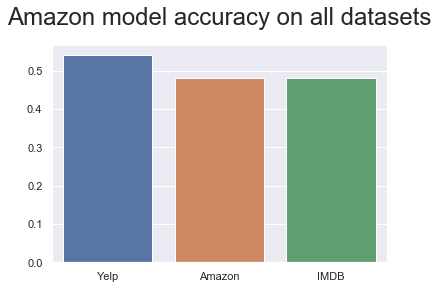

In [26]:
sns.barplot(x, yelp_tests).set_title('Amazon model accuracy on all datasets', size=24, pad=20);

# Train IMDB model

In [27]:
imdb_model = RNN_Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM);

optimizer = torch.optim.Adam(imdb_model.parameters());
imdb_model = imdb_model.to(device);
criterion = criterion.to(device);

train_model(imdb_model, imdb_train_iter, optimizer, criterion);

In [28]:
best_validation_loss = float('inf');

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(imdb_model, imdb_train_iter, optimizer, criterion);
    valid_loss, valid_acc = evaluate(imdb_model, imdb_val_iter, criterion);
    
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss;
        torch.save(imdb_model.state_dict(), 'amazon_train.pt');
    
    print('Epoch: {} / {}'.format(epoch + 1, N_EPOCHS));
    print('Training loss: {}, Training accuracy: {}'.format(train_loss, train_acc));
    print('Validation loss: {}, Validation accuracy: {}'.format(valid_loss, valid_acc));

Epoch: 1 / 10
Training loss: 0.692464276154836, Training accuracy: 0.5125
Validation loss: 0.6961976885795593, Validation accuracy: 0.5
Epoch: 2 / 10
Training loss: 0.6918382763862609, Training accuracy: 0.5010416666666667
Validation loss: 0.6986517906188965, Validation accuracy: 0.47999998927116394
Epoch: 3 / 10
Training loss: 0.694864018758138, Training accuracy: 0.49270833333333336
Validation loss: 0.6984530687332153, Validation accuracy: 0.5
Epoch: 4 / 10
Training loss: 0.691592029730479, Training accuracy: 0.5020833333333333
Validation loss: 0.6978853344917297, Validation accuracy: 0.5
Epoch: 5 / 10
Training loss: 0.6999058127403259, Training accuracy: 0.49166666666666664
Validation loss: 0.6970119476318359, Validation accuracy: 0.47999998927116394
Epoch: 6 / 10
Training loss: 0.6934840520222981, Training accuracy: 0.45729166666666665
Validation loss: 0.6969196796417236, Validation accuracy: 0.47999998927116394
Epoch: 7 / 10
Training loss: 0.6929864923159281, Training accuracy: 0.

# Test IMDB model on IMDB dataset

In [29]:
imdb_model.load_state_dict(torch.load('imdb_train.pt'));

imdb_test_loss, imdb_test_acc = evaluate(imdb_model, imdb_test_iter, criterion);
print('IMDB model on imdb dataset - test loss: {}, test accuracy: {}'.format(imdb_test_loss, imdb_test_acc));

IMDB model on imdb dataset - test loss: 0.7352506518363953, test accuracy: 0.5199999809265137


# Test IMDB model on Amazon dataset

In [30]:
amazon_test_loss, amazon_test_acc = evaluate(imdb_model, amazon_test_iter, criterion);
print('IMDB model on amazon dataset - test loss: {}, test accuracy: {}'.format(amazon_test_loss, amazon_test_acc));

IMDB model on amazon dataset - test loss: 0.7288976907730103, test accuracy: 0.5400000214576721


# Test IMDB model on YELP dataset

In [31]:
yelp_test_loss, yelp_test_acc = evaluate(imdb_model, yelp_test_iter, criterion);
print('Amazon model on Yelp dataset - test loss: {}, test accuracy: {}'.format(yelp_test_loss, yelp_test_acc));

Amazon model on Yelp dataset - test loss: 0.7534980773925781, test accuracy: 0.47999998927116394


In [32]:
x = ['Yelp', 'Amazon', 'IMDB'];
yelp_tests = [yelp_test_acc.item(), amazon_test_acc.item(), imdb_test_acc.item()];
print(yelp_tests);

[0.47999998927116394, 0.5400000214576721, 0.5199999809265137]


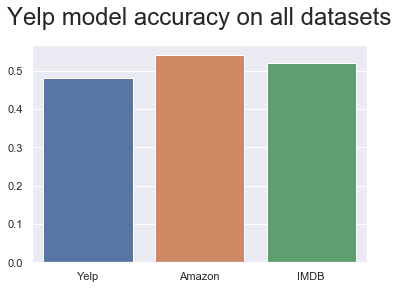

In [33]:
sns.barplot(x, yelp_tests).set_title('Yelp model accuracy on all datasets', size=24, pad=20);

# Train YELP model

In [34]:
yelp_model = RNN_Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM);

optimizer = torch.optim.Adam(yelp_model.parameters());
yelp_model = yelp_model.to(device);
criterion = criterion.to(device);

In [35]:
best_validation_loss = float('inf');

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(yelp_model, yelp_train_iter, optimizer, criterion);
    valid_loss, valid_acc = evaluate(yelp_model, yelp_val_iter, criterion);
    
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss;
        torch.save(yelp_model.state_dict(), 'yelp_train.pt');
    
    print('Epoch: {} / {}'.format(epoch + 1, N_EPOCHS));
    print('Training loss: {}, Training accuracy: {}'.format(train_loss, train_acc));
    print('Validation loss: {}, Validation accuracy: {}'.format(valid_loss, valid_acc));

Epoch: 1 / 10
Training loss: 0.7029915849367777, Training accuracy: 0.49270833333333336
Validation loss: 0.696694552898407, Validation accuracy: 0.47999998927116394
Epoch: 2 / 10
Training loss: 0.693554147084554, Training accuracy: 0.5229166666666667
Validation loss: 0.6977114677429199, Validation accuracy: 0.5
Epoch: 3 / 10
Training loss: 0.690119989713033, Training accuracy: 0.5072916666666667
Validation loss: 0.6981682777404785, Validation accuracy: 0.46000000834465027
Epoch: 4 / 10
Training loss: 0.6931949853897095, Training accuracy: 0.49270833333333336
Validation loss: 0.6963703632354736, Validation accuracy: 0.5199999809265137
Epoch: 5 / 10
Training loss: 0.6888681093851725, Training accuracy: 0.54375
Validation loss: 0.6947762370109558, Validation accuracy: 0.5199999809265137
Epoch: 6 / 10
Training loss: 0.7070043245951335, Training accuracy: 0.49375
Validation loss: 0.6915252208709717, Validation accuracy: 0.46000000834465027
Epoch: 7 / 10
Training loss: 0.692736045519511, Tra

# Test YELP model on YELP dataset

In [36]:
yelp_model.load_state_dict(torch.load('yelp_train.pt'));

yelp_test_loss, yelp_test_acc = evaluate(yelp_model, yelp_test_iter, criterion);
print('Amazon model on Yelp dataset - test loss: {}, test accuracy: {}'.format(yelp_test_loss, yelp_test_acc));

Amazon model on Yelp dataset - test loss: 0.680229127407074, test accuracy: 0.5


# Test YELP model on Amazon dataset

In [37]:
amazon_test_loss, amazon_test_acc = evaluate(yelp_model, amazon_test_iter, criterion);
print('IMDB model on amazon dataset - test loss: {}, test accuracy: {}'.format(amazon_test_loss, amazon_test_acc));

IMDB model on amazon dataset - test loss: 0.7052208781242371, test accuracy: 0.5


# Test YELP model on IMDB dataset

In [38]:
imdb_test_loss, imdb_test_acc = evaluate(yelp_model, imdb_test_iter, criterion);
print('IMDB model on imdb dataset - test loss: {}, test accuracy: {}'.format(imdb_test_loss, imdb_test_acc));

IMDB model on imdb dataset - test loss: 0.7041407823562622, test accuracy: 0.5


In [39]:
x = ['Yelp', 'Amazon', 'IMDB'];
yelp_tests = [yelp_test_acc.item(), amazon_test_acc.item(), imdb_test_acc.item()];
print(yelp_tests);

[0.5, 0.5, 0.5]


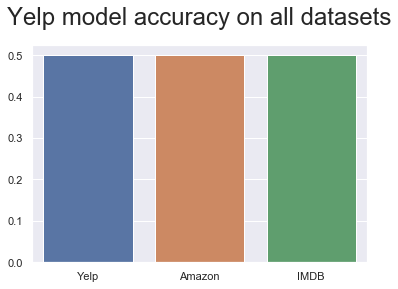

In [40]:
sns.barplot(x, yelp_tests).set_title('Yelp model accuracy on all datasets', size=24, pad=20);